In [1]:
%matplotlib notebook

import sys
import os

In [2]:
sys.path.append('d:/code/broadbean/')

In [3]:
import numpy as np
import qcodes as qc
import broadbean as bb

from matplotlib import pyplot as plt

from broadbean.plotting import plotter

In [4]:
# init instruments
from pytopo.qctools import instruments as instools

inst_list = []

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
awg = instools.create_inst(AWG5208, 'awg', address="TCPIP0::169.254.2.3::inst0::INSTR")
inst_list.append(awg)

station = qc.Station(*inst_list)

Connected to: TEKTRONIX AWG5208 (serial:B020206, firmware:FV:6.0.0242.0) in 0.21s


Snapshot: Could not update parameter:clock_source
Snapshot: Could not update parameter:external_sample_rate
Snapshot: Could not update parameter:sample_rate
Snapshot: Could not update parameter:clock_edge
Snapshot: Could not update parameter:decimation
Snapshot: Could not update parameter:coupling1
Snapshot: Could not update parameter:channel_range1
Snapshot: Could not update parameter:impedance1
Snapshot: Could not update parameter:coupling2
Snapshot: Could not update parameter:channel_range2
Snapshot: Could not update parameter:impedance2
Snapshot: Could not update parameter:trigger_operation
Snapshot: Could not update parameter:trigger_engine1
Snapshot: Could not update parameter:trigger_source1
Snapshot: Could not update parameter:trigger_slope1
Snapshot: Could not update parameter:trigger_level1
Snapshot: Could not update parameter:trigger_engine2
Snapshot: Could not update parameter:trigger_source2
Snapshot: Could not update parameter:trigger_slope2
Snapshot: Could not update par

In [5]:
gaussian = bb.PulseAtoms.gaussian
ramp = bb.PulseAtoms.ramp
delay = bb.PulseAtoms.waituntil

<IPython.core.display.Javascript object>


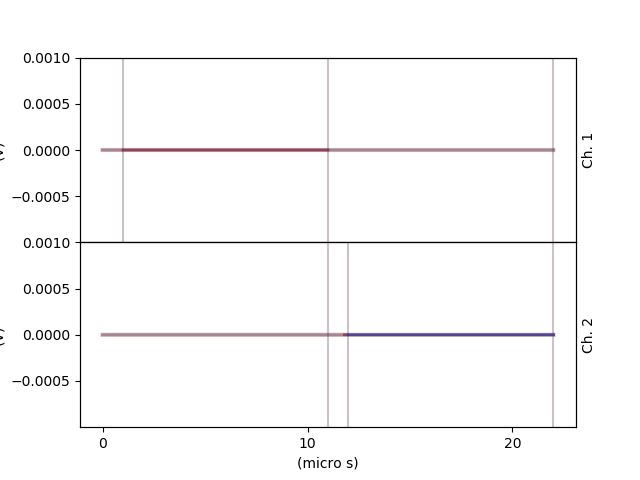

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [18]:
SR = 1e9
initial_delay = 1e-6
qb_pulse_len = 1e-5
ro_delay = 1e-6
ro_pulse_len = 1e-5
alz_trigger_len = 100e-9
alz_trigger_buf = 100e-9

spec_elem = bb.Element()

qubit = bb.BluePrint()
qubit.setSR(SR)
qubit.insertSegment(0, ramp, (0, 0), dur=initial_delay)
qubit.insertSegment(-1, ramp, (0, 0), dur=qb_pulse_len, name='qb_pulse')
qubit.insertSegment(-1, ramp, (0, 0), dur=ro_delay + ro_pulse_len)
qubit.setSegmentMarker('qb_pulse', (0, qb_pulse_len), 1)

readout = bb.BluePrint()
readout.setSR(SR)
readout.insertSegment(0, ramp, (0, 0), dur=initial_delay + qb_pulse_len)
readout.insertSegment(-1, ramp, (0, 0), dur=ro_delay, name='ro_delay')
readout.insertSegment(-1, ramp, (0, 0), dur=ro_pulse_len, name='ro_pulse')
readout.setSegmentMarker('ro_delay', (ro_delay - alz_trigger_len - alz_trigger_buf, alz_trigger_len), 1)
readout.setSegmentMarker('ro_pulse', (0, ro_pulse_len), 2)

spec_elem.addBluePrint(1, qubit)
spec_elem.addBluePrint(2, readout)

plotter(spec_elem)

<IPython.core.display.Javascript object>


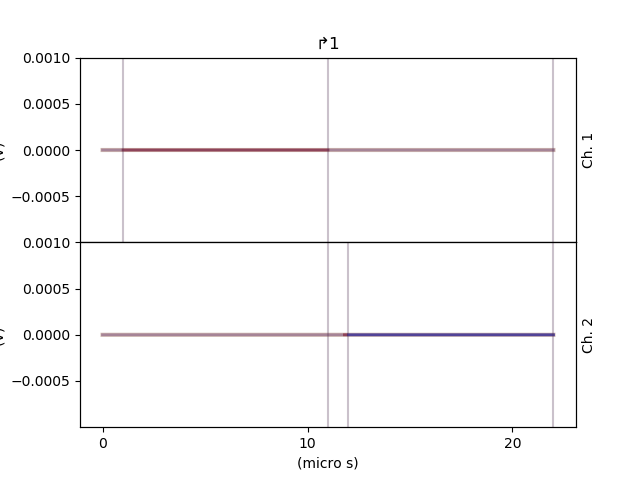

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [23]:
seq = bb.Sequence()
seq.addElement(1, spec_elem)
seq.setSR(SR)

seq.setChannelAmplitude(1, 1)
seq.setChannelAmplitude(2, 1)

seq.setSequencingTriggerWait(1, 0)
seq.setSequencingGoto(1, 1)

plotter(seq)

In [27]:
pkg = seq.outputForSEQXFile()
seqx = awg.makeSEQXFile(*pkg)
awg.sendSEQXFile(seqx, 'spec.seqx')

In [28]:
awg.loadSEQXFile('spec.seqx')